<a href="https://colab.research.google.com/github/alexandresoto/Especializacao_PUC-RJ_trabalhosprontos/blob/main/MVP_2_6_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Sprint 2 - Deep Learning
## Prof. Hugo Villamizar e Patrick Happ
### Aluno: Alexandre Souza Torres

## 1. Apresentação

### 1.1 Definição do problema

O objetivo do trabalho é apresentar um modelo binário de deep learning, treinando-o para que reconheça imagens. Foram utilizadas 983 imagens de pizza (pizza) e 983 imagens de pratos que não sejam pizza (not pizza). Todas as imagens foram redimensionadas para ter um comprimento lateral máximo de 512 pixels. Para desenvolver o trabalho, foi utilizada a biblioteca TensorFlow, além de otimizadores e callbacks.
A base de dados utilizada pode ser encontrada no site do Kaggle: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

## 2. Preparação de Dados

### 2.1 Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
from PIL import Image
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
plt.rcParams['font.size'] = 16

### 2.2 Importanto os dados

In [2]:
# Clonando um repositório GitHub:
# Para remover o diretório clonado no Colab
!rm -r /content/MVP_2/

# Copia as imagens para o Colab
!git clone https://github.com/alexandresoto/MVP_2.git

repo_dir = "MVP_2"
path = os.path.join(repo_dir, "pizza_not_pizza")

# Listando para armazenar as imagens
images = []

# Lendo as imagens no diretório
for filename in os.listdir(path):
    if os.path.isfile(os.path.join(path, filename)):  # Verifica se é um arquivo
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Verifica se o arquivo é uma imagem
            img = Image.open(os.path.join(path, filename))
            images.append(img)

rm: cannot remove '/content/MVP_2/': No such file or directory
Cloning into 'MVP_2'...
remote: Enumerating objects: 2144, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 2144 (delta 3), reused 349 (delta 3), pack-reused 1795
Receiving objects: 100% (2144/2144), 100.40 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (1966/1966), done.


### 2.3 Identificando o diretório, listando e imprimindo as classes

In [3]:
# Definindo a variável "data_dir" como o caminho para o diretório onde foi clonado o repositório "especializacao_data_science".
data_dir = "/content/MVP_2/pizza_not_pizza"

# Listando as imagens e suas respectivas classes
images = []
image_classes = []

# Lendo as imagens nos subdiretórios
for class_dir in os.listdir(data_dir):
    class_dir_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_dir_path):
        for filename in os.listdir(class_dir_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Verifica se o arquivo é uma imagem
                img = Image.open(os.path.join(class_dir_path, filename))
                images.append(img)
                image_classes.append(class_dir)  # Armazena a classe da imagem

# Imprimindo as classes
classes = os.listdir(data_dir)
print(classes)


['not pizza', 'pizza']


## 3. Treinamento e Validação

### 3.1 Definindo os geradores de dados

In [4]:
!rm -rf /content/MVP_2/
!git clone https://github.com/alexandresoto/MVP_2.git

# Usando o ImageDataGenerator do Keras para criar geradores de dados para o treinamento e validação do modelo.
# Definindo o tamanho das imagens de entrada que serão alimentadas (dimensões de 224x224 pixels)
img_size=224

# Definindo o batch size de imagens que serão usadas para atualizar os pesos do modelo a cada passo do treinamento
batch_size=32

# Definindo o diretório de treinamento:
train_dir = '/content/MVP_2/pizza_not_pizza'

# Criando os geradores de dados "train_gen" e "val_gen" para o treinamento e validação, respectivamente.
datagen = ImageDataGenerator(rescale=1/255.,
                            horizontal_flip=True,
                            vertical_flip=True,
                            zoom_range=0.025,
                            rotation_range=20,
                            validation_split=0.20)

train_gen = datagen.flow_from_directory(train_dir,
                                      batch_size=batch_size,
                                      target_size=(img_size,img_size),
                                      shuffle=True,
                                      subset='training',
                                      class_mode='binary',classes=['pizza', 'not pizza'])

val_gen = datagen.flow_from_directory(train_dir,
                                      batch_size=batch_size,
                                      target_size=(img_size,img_size),
                                      shuffle=False,
                                      subset='validation',
                                      class_mode='binary',classes=['pizza', 'not pizza'])


Cloning into 'MVP_2'...
remote: Enumerating objects: 2144, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 2144 (delta 3), reused 349 (delta 3), pack-reused 1795
Receiving objects: 100% (2144/2144), 100.40 MiB | 24.25 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [5]:
# Mostrando as classes presentes:
train_gen.class_indices

{'pizza': 0, 'not pizza': 1}

### 3.2 Exibindo imagens e rótulos

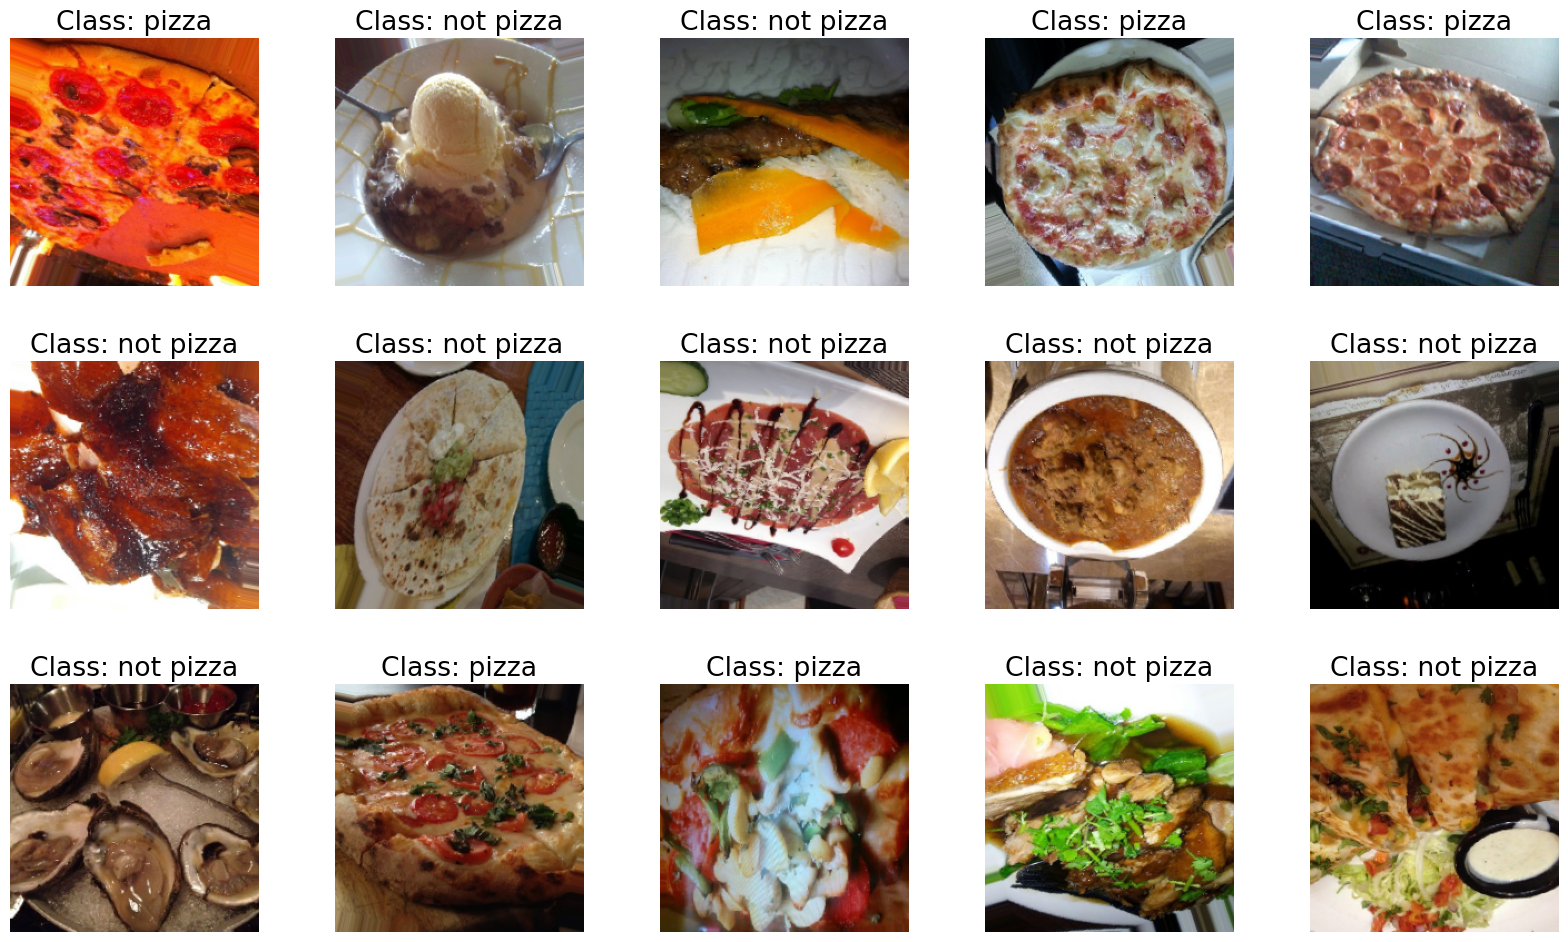

In [6]:
# Selecionando 15 imagens do conjunto de treinamento.
labels = [k for k in train_gen.class_indices] # lista que contém o nome das classes
sample_generate = train_gen.__next__() # exibindo um conjunto de exemplos
# Acessando as imagens e rótulos:
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1) # exibindo as imagens
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[int(titles[i])]}')
    plt.axis("off") # desativando e ajustando eixos

O código acima traz uma amostra de 15 imagens aleatórias para visualização de erros e acertos na classificação.

### 3.3 Definição da arquitetura do Modelo

In [7]:
# Importanto e construindo o modelo MobileNet (arquitetura de rede neural convolucional - CNN): "weights =
# 'imagenet'" define o conjunto de pesos pré-treinados que serão carregados no modelo; "include_top=False"
# define se a camada totalmente conectada (topo) do modelo deve ser incluída ou não.

base_model=MobileNet(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)) # especificando o tamanho da entrada que o modelo espera receber

17225924/17225924 [==============================] - 1s 0us/step


In [8]:
# Exibindo um resumo da arquitetura do modelo MobileNet:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [9]:
# Procurando o índice de camada conv_dw_4_relu (ReLU):
index = None
for idx, layer in enumerate(base_model.layers):
    if layer.name == 'conv_dw_4_relu (ReLU)':
        index = idx
        break # utilizando o comando break para interromper o loop assim que a camada desejada é encontrada

# Procurando o índice da camada chamada 'conv_pw_4_relu' dentro das camadas do base_model (MobileNet) usando o nome da camada
layer_names = [layer.name for layer in base_model.layers]
layer_idx = layer_names.index('conv_pw_4_relu') # armazena o índice encontrado para a camada 'conv_pw_4_relu'

layer_idx

29

O resultado 29 representa o índice da camada 'conv_pw_4_relu' dentro das camadas do base_model (MobileNet). Usando a função index() para procurar a camada 'conv_pw_4_relu' na lista layer_names, ela retornou o valor 29, indicando que essa camada está na posição 29 da lista.

In [10]:
# Adicionando camadas personalizadas ao base_model (MobileNet) para criar o modelo completo para a classificação binária.

for layer in base_model.layers[:-29]: # percorrendo todas as camadas do base_model exceto as últimas 29 camadas
    layer.trainable=False # as camadas não serão treinadas durante o treinamento do modelo


last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), # usando o otimizador Adam para compilar com uma taxa de aprendizado (learning rate) de 0.0001
             loss='binary_crossentropy',
             metrics=['accuracy'])


model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1) # salvando o modelo com os melhores resultados em relação à perda na validação

# Parar o treinamento se a perda na validação não melhorar após um certo número de épocas (patience=3).
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

### 3.4 Iniciando treinamento do Modelo

In [11]:
# Iniciando o treinamento do modelo usando o conjunto de dados de treinamento (train_gen) e o conjunto de dados de validação (val_gen):
try:
    history = model.fit(train_gen, # fornece as imagens e rótulos de treinamento para o modelo durante o treinamento
                        epochs=5, # número de épocas de treinamento
                        validation_data=val_gen,
                        callbacks=[checkpoint,earlystopping]) # ModelCheckpoint e o EarlyStopping serão executados durante o treinamento para salvar os melhores resultados
# e parar o treinamento se a perda na validação não melhorar após um certo número de épocas
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8482
Epoch 1: val_loss improved from inf to 0.21687, saving model to model.h5
50/50 [==============================] - 208s 4s/step - loss: 0.3409 - accuracy: 0.8482 - val_loss: 0.2169 - val_accuracy: 0.9209
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9231
Epoch 2: val_loss did not improve from 0.21687
50/50 [==============================] - 203s 4s/step - loss: 0.1939 - accuracy: 0.9231 - val_loss: 0.2764 - val_accuracy: 0.8878
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9530
Epoch 3: val_loss did not improve from 0.21687
50/50 [==============================] - 185s 4s/step - loss: 0.1252 - accuracy: 0.9530 - val_loss: 0.3110 - val_accuracy: 0.8622
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9619
Epoch 4: val_loss improved from 0.21687 to 0.15193, saving model to mod

O resultado acima mostra a perda de validação diminuindo nas primeiras épocas. É importante observar que a precisão de validação também é alta, o que indica que o modelo está generalizando bem para dados não vistos.

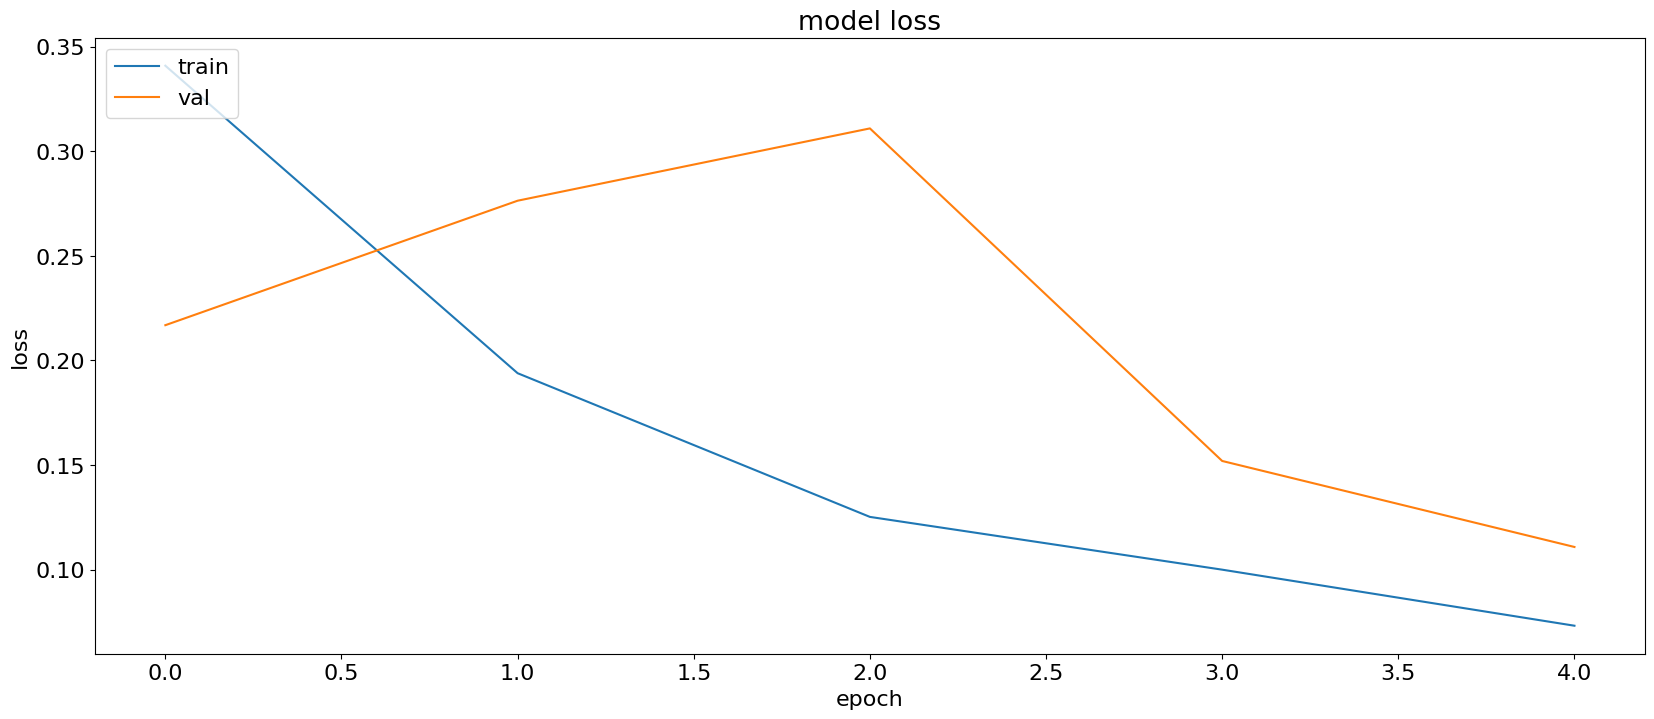

In [12]:
#Exibindo o gráfico para visualizar a perda (loss) durante o treinamento do modelo:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

O gráfico acima é uma maneira de visualizar a progressão da perda durante o treinamento. Vemos que a perda de treinamento (linha azul) diminui à medida que as épocas avançam, e a perda de validação (linha laranja) também segue uma tendência semelhante, com algumas oscilações. Isso indica que o modelo está aprendendo a partir dos dados de treinamento e também generalizando bem para os dados de validação.

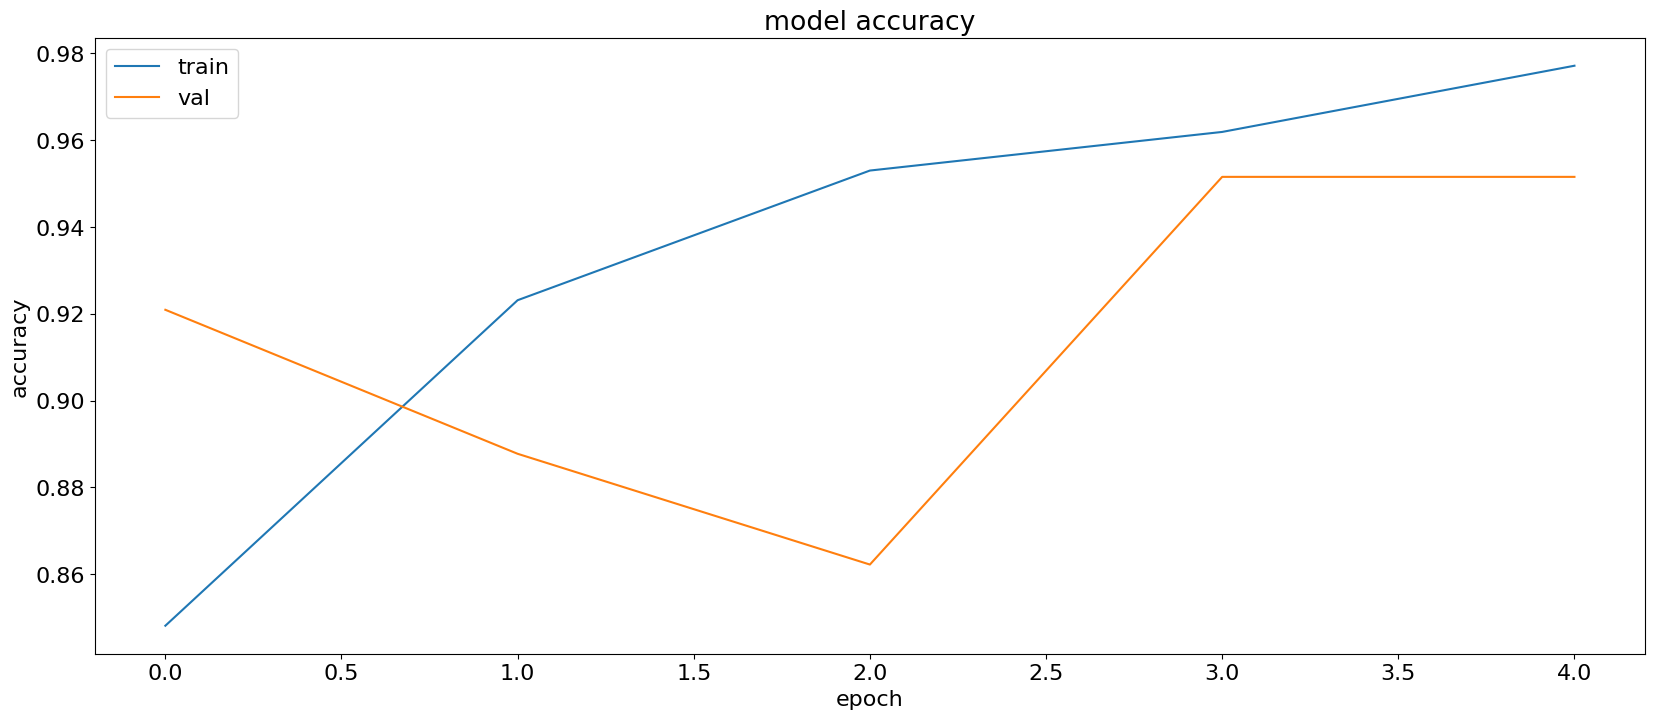

In [13]:
# Exibindo o gráfico para visualizar a precisão (accuracy) durante o treinamento do modelo:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Esse gráfico de precisão é uma maneira de visualizar o desempenho do modelo durante o treinamento. Vemos que a precisão de treinamento (linha azul) aumenta à medida que as épocas avançam, e a precisão de validação (linha laranja) também deve seguir uma tendência semelhante, com algumas oscilações. Isso indica que o modelo está melhorando sua capacidade de classificação à medida que é treinado, e também está generalizando bem para os dados de validação.

In [14]:
# Carregando o modelo treinado com "model.h5":
best_model=tf.keras.models.load_model('model.h5')

# Fazendo previsões no conjunto de dados de validação (val_gen) usando o modelo "model.h5":
y_test = val_gen.classes
y_pred_val = best_model.predict(val_gen)
y_pred_val2 = y_pred_val.copy()

13/13 [==============================] - 27s 2s/step


O resultado indica que o modelo fez previsões para as amostras do conjunto de validação em 13 etapas (batches). Cada etapa processou um lote (batch) de amostras.

## 4. Avaliação do Modelo

### 4.1 Cálculos das métricas do Modelo

In [15]:
# Calculando métricas de avaliação para o desempenho do modelo de classificação em relação ao conjunto de validação:
y_pred_val[y_pred_val2>=0.5]=1
y_pred_val[y_pred_val2<0.5]=0


from sklearn.metrics import classification_report, confusion_matrix,roc_curve,roc_auc_score

print(classification_report(y_test,y_pred_val,target_names = labels))

              precision    recall  f1-score   support

       pizza       0.95      0.94      0.95       196
   not pizza       0.94      0.95      0.95       196

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392



Macro avg e Weighted avg são médias das métricas de precisão, recall e F1-score, calculadas para as classes. As métricas Precisão, Recall e F1-score são importantes em tarefas de classificação. Ambos resultam em aproximadamente 0.95, o que mostra a qualidade geral do modelo em ambas as classes. A acurácia é uma métrica geral que mede a proporção de amostras classificadas corretamente pelo modelo. No modelo, vemos que a acurácia é de aproximadamente 0.95, o que é um ótimo resultado.

### 4.2 Matriz de Confusão

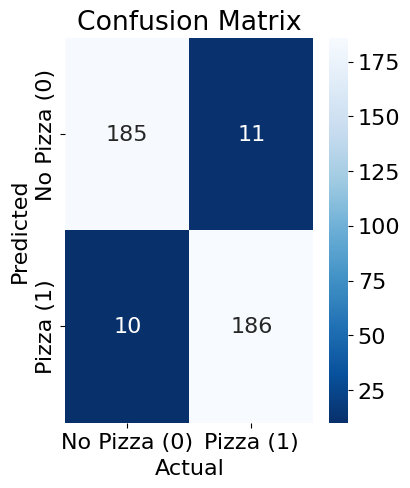

In [16]:
# Exibindo a Matriz de Confusão:
plt.figure(figsize=(4,5))
sns.heatmap(confusion_matrix(y_test,y_pred_val),annot=True,cmap='Blues_r',fmt='.3g',
            xticklabels=['No Pizza (0)','Pizza (1)'], yticklabels=['No Pizza (0)','Pizza (1)'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

O modelo classificou corretamente 186 amostras de classe "pizza" como "pizza" (Verdadeiros Positivos), e 185 amostras "not pizza" como "not pizza" (Verdadeiros Negativos). Em contrapartida o modelo classificou incorretamente 11 amostras da classe "not pizza" como "pizza", e 10 amostras da classe "pizza" como "not pizza". Dessa forma, o resultado da Matriz de Confusão mostra que o modelo está tendo resultados satisfatórios.

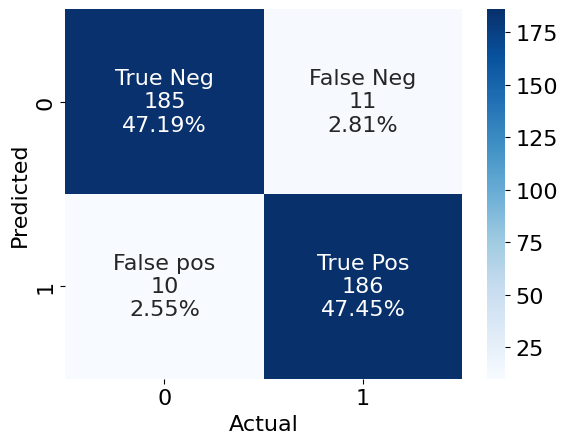

In [17]:
group_names = ['True Neg','False Neg','False pos','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix(y_test,y_pred_val) .flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix(y_test,y_pred_val).flatten()/np.sum(confusion_matrix(y_test,y_pred_val))]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test,y_pred_val), annot=labels, fmt='', cmap='Blues')

plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title("Confusion Matrix")
plt.show()

A Matriz de Confusão acima mostra de maneira analítica os percentuais acertos e erros. Para a classe "pizza" indica que o modelo identificou corretamente cerca de 87% das amostras. Para a classe "not pizza" indica que o modelo identificou corretamente cerca de 95% das amostras.

### 4.3 Curva ROC e AUC

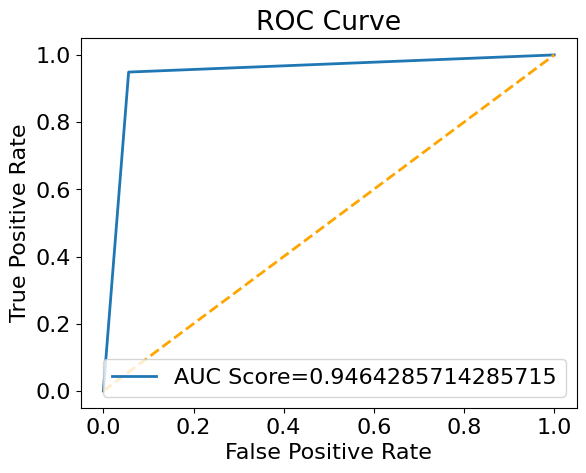

In [18]:
# Exibindo a curva ROC (Receiver Operating Characteristic) e calculando a área sob a curva ROC (AUC) para avaliar o desempenho do modelo de classificação:
fpr,tpr,_=roc_curve(y_test,y_pred_val)
auc=roc_auc_score(y_test,y_pred_val)
plt.plot(fpr,tpr,label="AUC Score="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

A métrica ROC (AUC) mostra a qualidade do classificador, e um valor próximo de 1 indica um bom desempenho de classificação. Vemos que a curva ROC está próxima do canto superior esquerdo, indicando um bom desempenho do modelo em separar as classes.

## Conclusão

Após utilizarmos técnicas de Deep Learning, processamento de imagens e avaliação de modelos de classificação, é possível concluir, com base nesses resultados, que o modelo desenvolvido foi capaz de fazer previsões precisas e confiáveis na tarefa de classificação entre "pizza" e "not pizza", com uma acurácia de 92%, atingindo uma ótima performance, com alta precisão. Os resultados indicam que o modelo é capaz de realizar a tarefa com grande eficácia, sendo útil em cenários práticos de classificação.